# 安装包

1. 安装keras-preprocessing ```pip install keras-preprocessing==1.0.9```

2. 解压keras-contrib-master.zip ```unzip work/keras-contrib-master.zip```

3. 安装keras-contrib-master ```python keras-contrib-master/setup.py install```

4. 解压bi-lstm-crf-master.zip ```unzip work/bi-lstm-crf-master.zip```

5. 安装bi-lstm-crf ```python bi-lstm-crf-master/setup.py install```

# 配置环境，并导入包

如果上面的步骤执行成功后，该步骤提示模块dl_segmenter不存在，请重启kernel后再执行这一步。重启kernel的方法参考实验手册

In [1]:
#配置环境，并导入包
import sys
path1 = "./tookit/bi-lstm-crf-master"
sys.path.append(path1)
path2 = "./tookit/keras-contrib-master"
sys.path.append(path2)
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from dl_segmenter import get_or_create, save_config,DLSegmenter
from dl_segmenter.custom.callbacks import LRFinder, SGDRScheduler, WatchScheduler
from dl_segmenter.data_loader import DataLoader
from dl_segmenter.utils import make_dictionaries
import os
import re

Using TensorFlow backend.
/home/liyang/anaconda3/envs/py362/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/liyang/anaconda3/envs/py362/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/liyang/anaconda3/envs/py362/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/liyang/anaconda3/

# 解压数据

```unzip work/people-2014.zip```

# 数据预处理

1.将标注的语料转化成BIS形式，并合并在一个文件中

In [2]:
#B:表示语句块的开始，I:表示非语句块的开始，S:表示单独成词
#示例如下：
# 华尔街/nsf 股市/n 。/w   ->    华 尔 街 股 市 。  B-nsf I-nsf I-nsf B-n I-n S-w
def print_process(process):
    num_processed = int(30 * process)
    num_unprocessed = 30 - num_processed
    print(
        f"{''.join(['['] + ['='] * num_processed + ['>'] + [' '] * num_unprocessed + [']'])}, {(process * 100):.2f} %")


def convert_to_bis(source_dir, target_path, log=False, combine=False, single_line=True):
    print("开始转化...")
    for root, dirs, files in os.walk(source_dir):
        total = len(files)
        tgt_dir = target_path + root[len(source_dir):]

        print(tgt_dir)
        for index, name in enumerate(files):
            file = os.path.join(root, name)
            bises = process_file(file)
            if combine:
                _save_bises(bises, target_path, write_mode='a', single_line=single_line)
            else:
                os.makedirs(tgt_dir, exist_ok=True)
                _save_bises(bises, os.path.join(tgt_dir, name), single_line=single_line)
            if log:
                print_process((index + 1) / total)
    print("转化完成")


def _save_bises(bises, path, write_mode='w+', single_line=True):
    with open(path, mode=write_mode, encoding='UTF-8') as f:
        if single_line:
            for bis in bises:
                sent, tags = [], []
                for char, tag in bis:
                    sent.append(char)
                    tags.append(tag)
                sent = ' '.join(sent)
                tags = ' '.join(tags)
                f.write(sent + "\t" + tags)
                f.write('\n')
        else:
            for bis in bises:
                for char, tag in bis:
                    f.write(char + "\t" + tag + "\n")
                f.write("\n")


def process_file(file):
    with open(file, 'r', encoding='UTF-8') as f:
        text = f.readlines()
        bises = _parse_text(text)
    return bises


def _parse_text(text: list):
    bises = []
    for line in text:
        # remove POS tag
        line, _ = re.subn('\\n', '', line)
        if line == '' or line == '\n':
            continue
        words = re.split('\s+', line)

        if len(words) > MAX_LEN_SIZE:
            texts = re.split('[。？！，.?!,]/w', line)
            if len(min(texts, key=len)) > MAX_LEN_SIZE:
                continue
            bises.extend(_parse_text(texts))
        else:
            bises.append(_tag(words))
    return bises

#给指定的一行文本打上BIS标签
def _tag(words): 
    bis = []
    # words = list(map(list, words))
    pre_word = None
    for word in words:
        pos_t = None
        tokens = word.split('/')
        if len(tokens) == 2:
            word, pos = tokens
        elif len(tokens) == 3:
            word, pos_t, pos = tokens
        else:
            continue

        word = list(word)
        pos = pos.upper()

        if len(word) == 0:
            continue
        if word[0] == '[':
            pre_word = word
            continue
        if pre_word is not None:
            pre_word += word
            if pos_t is None:
                continue
            elif pos_t[-1] != ']':
                continue
            else:
                word = pre_word[1:]
                pre_word = None

        if len(word) == 1:
            bis.append((word[0], 'S-' + pos))
        else:
            for i, char in enumerate(word):
                if i == 0:
                    bis.append((char, 'B-' + pos))
                else:
                    bis.append((char, 'I-' + pos))
    # bis.append(('\n', 'O'))
    return bis

corups_dir="./tookit/people-2014/train" #指定存放语料库的文件夹，程序将会递归查找目录下的文件。
output_path="./tookit/bi-lstm-crf-master/data/2014_processed"  #指定标记好的文件的输出路径。
combine = True
MAX_LEN_SIZE =  150   #处理后的最大语句长度（将原句子按标点符号断句，若断句后的长度仍比最大长度长，将忽略

log = False
convert_to_bis(corups_dir, output_path, log, combine)

开始转化...
./tookit/bi-lstm-crf-master/data/2014_processed
./tookit/bi-lstm-crf-master/data/2014_processed/0106
./tookit/bi-lstm-crf-master/data/2014_processed/0112
./tookit/bi-lstm-crf-master/data/2014_processed/0108
./tookit/bi-lstm-crf-master/data/2014_processed/0110
./tookit/bi-lstm-crf-master/data/2014_processed/0107
./tookit/bi-lstm-crf-master/data/2014_processed/0102
./tookit/bi-lstm-crf-master/data/2014_processed/0118
./tookit/bi-lstm-crf-master/data/2014_processed/0122
./tookit/bi-lstm-crf-master/data/2014_processed/0120
./tookit/bi-lstm-crf-master/data/2014_processed/0104
./tookit/bi-lstm-crf-master/data/2014_processed/0117
./tookit/bi-lstm-crf-master/data/2014_processed/0103
./tookit/bi-lstm-crf-master/data/2014_processed/0109
./tookit/bi-lstm-crf-master/data/2014_processed/0119
./tookit/bi-lstm-crf-master/data/2014_processed/0105
./tookit/bi-lstm-crf-master/data/2014_processed/0116
./tookit/bi-lstm-crf-master/data/2014_processed/0113
./tookit/bi-lstm-crf-master/data/2014_proce

2.生成字典

In [3]:
file_path = "./tookit/bi-lstm-crf-master/data/2014_processed" #用于生成字典的标注文件
src_dict_path = "./tookit/bi-lstm-crf-master/config/src_dict.json" #源字典保存路径
tgt_dict_path = "./tookit/bi-lstm-crf-master/config/tgt_dict.json" #目标字典保存路径
min_freq = 1 #词频数阈值，小于该阈值的词将被忽略
print("开始生成...")
make_dictionaries(file_path,
                  src_dict_path=src_dict_path,
                  tgt_dict_path=tgt_dict_path,
                  filters="\t\n",
                  oov_token="<UNK>",
                  min_freq=min_freq)
print("生成字典结束.")

开始生成...
生成字典结束.


3.转化成h5文件

In [4]:
#可将文本文件2014_processed转换为hdf5格式，提升训练速度

src_dict_path = "./tookit/bi-lstm-crf-master/config/src_dict.json" #源字典保存路径
tgt_dict_path = "./tookit/bi-lstm-crf-master/config/tgt_dict.json" #目标字典保存路径
txt_path ="./tookit/bi-lstm-crf-master/data/2014_processed" #BIS标注的文本文件路径
h5_path = "./tookit/bi-lstm-crf-master/data/2014_processed.h5" #转换为hdf5格式的保存路径
seq_len = 150  #语句长度
data_loader = DataLoader(src_dict_path, tgt_dict_path,
                             batch_size=1,
                             max_len=seq_len,
                             sparse_target=False)
print("开始转化...")
data_loader.load_and_dump_to_h5(txt_path, h5_path, encoding='utf-8')
print("转化完成.")

开始转化...
转化完成.


# 配置相关参数

In [3]:
h5_dataset_path = "./tookit/bi-lstm-crf-master/data/2014_processed.h5"  # 转换为hdf5格式的数据集
config_save_path = "./tookit/bi-lstm-crf-master/config/default-config.json"  # 模型配置路径
weights_save_path = "./tookit/bi-lstm-crf-master/models/weights.{epoch:02d}-{val_loss:.2f}.h5"  # 模型权重保存路径
init_weights_path = "./tookit/bi-lstm-crf-master/models/weights.32--0.18.h5"  # 预训练模型权重文件路径
#embedding_file_path = "../data/sgns.renmin.word"  # 词向量文件路径，若不使用设为None
embedding_file_path = None  # 词向量文件路径，若不使用设为None

src_dict_path = "./tookit/bi-lstm-crf-master/config/src_dict.json"  # 源字典路径
tgt_dict_path = "./tookit/bi-lstm-crf-master/config/tgt_dict.json"  # 目标字典路径
batch_size = 32
epochs = 10



# GPU 下用于选择训练的GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

data_loader = DataLoader(src_dict_path=src_dict_path,
                         tgt_dict_path=tgt_dict_path,
                         batch_size=batch_size)

steps_per_epoch = 2000
validation_steps = 20

config = {
    "vocab_size": data_loader.src_vocab_size,
    "chunk_size": data_loader.tgt_vocab_size,
    "embed_dim": 300,
    "bi_lstm_units": 256,
     "max_num_words": 20000,
    "dropout_rate": 0.1
}


# 加载数据

In [4]:
#加载数据,并将数据分割成训练集合验证集

X_train, Y_train, X_valid, Y_valid = DataLoader.load_data(h5_dataset_path, frac=0.8)

# 定义并训练模型





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
2000/2000 [==============================] - 2542s 1s/step - loss: 0.4544 - crf_accuracy: 0.8656 - val_loss: 0.1142 - val_crf_accuracy: 0.9208


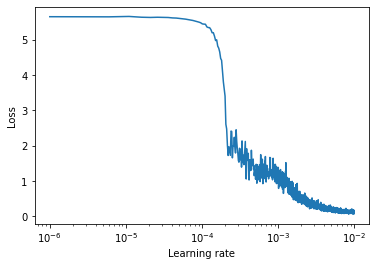

In [5]:
#定义模型
tokenizer = get_or_create(config,
                          optimizer=Adam(),
                          embedding_file=embedding_file_path,
                          src_dict_path=src_dict_path,
                          weights_path=None)
print(tokenizer)
save_config(tokenizer, config_save_path)

#ModelCheckpoint 保存最佳模型
ck = ModelCheckpoint(weights_save_path,
                     save_best_only=True,
                     save_weights_only=True,
                     monitor='val_loss',
                     verbose=0)
#创建日志
log = TensorBoard(log_dir='./tookit/bi-lstm-crf-master/logs',
                  histogram_freq=0,
                  batch_size=data_loader.batch_size,
                  write_graph=True,
                  write_grads=False)

# 使用LRFinder寻找有效的学习率
lr_finder = LRFinder(1e-6, 1e-2, steps_per_epoch, epochs=1)  # => (2e-4, 3e-4)
lr_scheduler = WatchScheduler(lambda _, lr: lr / 2, min_lr=2e-4, max_lr=4e-4, watch="val_loss", watch_his_len=2)
lr_scheduler = SGDRScheduler(min_lr=4e-5, max_lr=1e-3, steps_per_epoch=steps_per_epoch,
                             cycle_length=15,
                             lr_decay=0.9,
                             mult_factor=1.2)


#训练模型
tokenizer.model.fit_generator(data_loader.generator_from_data(X_train, Y_train),
                              epochs=1,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=data_loader.generator_from_data(X_valid, Y_valid),
                              validation_steps=validation_steps,
                              callbacks=[ck, log, lr_finder])
#画出损失函数
lr_finder.plot_loss()


# 词性标注测试

1. 重启kernel

请按照实验手册上面的操作重启kernel

2. 导入包

In [1]:
#配置环境，并导入包
import sys
path1 = "./tookit/bi-lstm-crf-master"
sys.path.append(path1)
path2 = "./tookit/keras-contrib-master"
sys.path.append(path2)
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from dl_segmenter import get_or_create, save_config,DLSegmenter
from dl_segmenter.custom.callbacks import LRFinder, SGDRScheduler, WatchScheduler
from dl_segmenter.data_loader import DataLoader
from dl_segmenter.utils import make_dictionaries
import os

Using TensorFlow backend.
/home/liyang/anaconda3/envs/py362/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/liyang/anaconda3/envs/py362/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/liyang/anaconda3/envs/py362/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/liyang/anaconda3/

In [2]:
segmenter: DLSegmenter = get_or_create("./tookit/bi-lstm-crf-master/config/default-config.json",
                                       src_dict_path="./tookit/bi-lstm-crf-master/config/src_dict.json",
                                       tgt_dict_path="./tookit/bi-lstm-crf-master/config/tgt_dict.json",
                                       weights_path="./tookit/bi-lstm-crf-master/models/weights.32--0.18.h5")
texts = [ 
   "华为是全球领先的ICT（信息与通信）基础设施和智能终端提供商，"
    "致力于把数字世界带入每个人、每个家庭、每个组织，构建万物互联的智能世界。"
    "我们在通信网络、IT、智能终端和云服务等领域为客户提供有竞争力、安全可信赖的产品、解决方案与服务，"
    "与生态伙伴开放合作，持续为客户创造价值，释放个人潜能，丰富家庭生活，激发组织创新。"
    "华为坚持围绕客户需求持续创新，加大基础研究投入，厚积薄发，推动世界进步。"
    "华为成立于1987年，是一家由员工持有全部股份的民营企业，目前有18万员工，业务遍及170多个国家和地区。"       
]


for sent, tag in segmenter.decode_texts(texts):
    print(*zip(sent,tag))







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<class 'str'>
2.2.4
('华为', 'a') ('是', 'vshi') ('全', 'a') ('球', 'q') ('领先', 'vi') ('的', 'ude1') ('I', 'ng') ('C', 'x') ('T', 'w') ('（', 'w') ('信', 'n') ('息', 'c') ('与', 'qv') ('通信', 'vn') ('）', 'w') ('基', 'rz') ('础设施', 'nr') ('和', 'cc') ('智', 'n') ('能', 'v') ('终', 'd') ('端', 'v') ('提', 'v') ('供', 'x') ('商', 'w') ('，', 'w') ('致力于', 'v') ('把', 'pba') ('数字', 'n') ('世界', 'vi') ('带入', 'v') ('每', 'n') ('个人', 'n') ('、', 'w') ('每', 'n') ('个', 'q') ('家庭', 'nz') ('、', 'w') ('每', 'n') ('个', 'q') ('组织', 'n') ('，', 'w') ('构', 'd') ('建', 'v') ('万', 'w') ('物互', 'nr') ('联', 'ng') ('的', 'ude1') ('智', 'n') ('能', 'v') ('世界', 'vi') ('。', 'w') ('我们', 'rr') ('在', 'p') ('通信', 'vn') ('网络', 'n') ('、', 'w') ('I', 'ng') ('T', 'w') ('、', 'w') ('智', 'n') ('能', 'v') ('终', 'd') ('端', 'v') ('和', 'cc') ('云',